In [17]:
import requests
import json
import numpy as np
import gen_ai_web_server.llm_client as llm_Client

TARGET_URL = "http://localhost:5000"
REQUEST_URL = f"{TARGET_URL}/request"
VOCAB_URL = f"{TARGET_URL}/vocab"
headers = {
    "Content-Type": "application/json",
    "Connection": "keep-alive",

}
SAMPLE = False


prompt_math = "What is 14+5*34?"
prompt_explain = "Explain the concept of a derivative."
prompt_weather = "What is the weather likely to be in December?"

question = prompt_math
data = {
    "prompt": [{"role":"user", "content":question}],
    "process_logits": True,
    "run_config": {"do_sample":SAMPLE,
    "debug_mode": True}
}


In [18]:
print("Sent")
vocab = requests.get(VOCAB_URL).json()
response = requests.post(REQUEST_URL, data=json.dumps(data), headers=headers).json()
client = llm_Client.Client()
raw_resp = client.send_request(data["prompt"], process_logits=True)

response = client.extract_response(raw_resp)
print(response)
response = raw_resp
#print(response.get("response"))

Sent
 To solve the expression 14 + 5 * 34, we need to follow the order of operations, which is Parentheses, Exponents, Multiplication and Division (from left to right), Addition and Subtraction (from left to right). This rule is often abbreviated as PEMDAS.

In this expression, there are no parentheses or exponents, so we move on to multiplication:

5 * 34 = 170

Now, we perform the addition:

14 + 170 = 184

So, 14 + 5 * 34 equals 184.


In [19]:
import datetime

def normalise_scores(scores: list):

    norm_scores = []
    per_token_len = len(scores)
    for i in range(per_token_len):
        score = scores[i][0]
        min = np.min(score)
        max = np.max(score)
        norm_scores.append(list([(i-min)/(max-min) for i in score]))

    return norm_scores

def score_rank(scores: list, N: int):
    return list(reversed(sorted(range(len(scores)), key = lambda sub: scores[sub])[-N:]))

def get_scored_tokens(scores, rev_vocab: dict, N: int):
    return [{"v":rev_vocab.get(i), "s":scores[i],"k":i} for i in score_rank(scores, N)]

def dump_vocab(rev_vocab: dict):
    with open("vocab.json", "w") as f:
        json.dump(rev_vocab, f)

def eval_top_compare(n_score1, n_score2):
    stdScoreTop = n_score1
    stdScore2nd = n_score2
    return int((stdScoreTop-stdScore2nd)*100/stdScore2nd)

def eval_std_compare(n_scores,full_scores):
    stdScoreN = np.std(n_scores)
    stdScoreFull = np.std(full_scores)
    return (stdScoreN-stdScoreFull)*100/stdScoreFull, stdScoreN, stdScoreFull

def eval_mean_compare(n_scores,full_scores):
    mScoreN = np.mean(n_scores)
    mScoreFull = np.mean(full_scores)
    return mScoreN/mScoreFull, mScoreN, mScoreFull

def identify_css_class(metric_value):
    if metric_value > 0 and metric_value <= 5:
        return "similar"
    elif metric_value > 5 and metric_value <= 15:
        return "diff"
    elif metric_value > 15 and metric_value <= 25:
        return "mid_diff"
    elif metric_value > 25 and metric_value <= 35:
        return "high_diff"
    elif metric_value > 35 and metric_value <= 50:
        return "very_high_diff"
    elif metric_value > 50:
        return "divergent"
    else:
        return ""

def build_css():
    return """
    .similar { background-color: #66FF00; }
    .diff { background-color: #FFD700; }
    .mid_diff { background-color: #FFC72C; }
    .high_diff { background-color: #fd5c63; }
    .very_high_diff { background-color: #FF69B4; }
    .divergent { background-color: #D2122E; }
    """

def write_html(text, sample):
    timestamp = datetime.datetime.now()
    with open(f"output{datetime.datetime.timestamp(timestamp)}_{sample}.html", "w", encoding="utf-8") as f:
        f.write("<html>")
        f.write("<head><style>")
        f.write(build_css())
        f.write("</style></head>")
        f.write("<body>")
        f.write(f"<div>Question: {question}</div><br/><br/>")
        f.write(f"<div>Sampling?: {sample}</div><br/><br/>")
        f.write(f"<div>Timestamp: {timestamp}</div><br/><br/>")
        f.write("<div style='white-space: pre-wrap;'")
        f.write(text)
        f.write("</div></body>")
        f.write("</html>")

def to_text(logits:list, rev_vocab:dict):
    text = [rev_vocab.get(i) for i in logits]   
    return " ".join(text).replace("▁"," ")

def get_generated_logits(response:dict)->list:
    #logits shape [num of new tokens, 0, total tokens - increasing by one]
    logits = response.get("logits")
    return logits[-1][0][-len(logits)+1:]

def get_generated_scores(response:dict)->np.ndarray:
    #scores shape [num of new tokens, 0, vocab size]
    scores = response.get("scores")
    return np.squeeze(scores)

def get_score_by_logit(logit, scores):
    return scores[logit]


def build_html_page(response:dict, rev_vocab:dict, sampling:bool):
    txt = ""
    logits = get_generated_logits(response)
    scores = get_generated_scores(response)
    for i in range(0,len(logits)):

        metric = 0
        if sampling==False:
            topN = get_scored_tokens(scores[i], rev_vocab, 2)
            scoreN = [i["s"] for i in topN]
            metric = eval_top_compare(scoreN[0],scoreN[1])
        else:
        
          
            score0 = np.max(scores[i])
            score1 = get_score_by_logit(logits[i],scores[i])
            metric = eval_top_compare(score0,score1)


       
        token=to_text([logits[i]], rev_vocab)

        token_html = ""
        if token == "<0x0A>":
            token_html=f"<br/><a data='{metric}' class='{identify_css_class(metric)}'>-</a>"
        else:
            token_html = f"<a data='{metric}' class='{identify_css_class(metric)}'>{token}</a>"

        txt+=f"<span title={metric}>{token_html}</span>"
        # print(f"{i} {stdScoreFull, stdScoreN, mScoreFull, mScoreN, np.min(scores)}") 
        max_scoring_token = rev_vocab[np.argmax(scores[i])].replace("▁"," ")
        print(f"Score: {metric},\tSelected Text: {token},\t\tMax Scoring Text: {max_scoring_token}")

    write_html(txt,sampling)



145
(146, 32064)
Score: 3,	Selected Text:  To,		Max Scoring Text:  To
Score: 8,	Selected Text:  solve,		Max Scoring Text:  solve
Score: 1,	Selected Text:  the,		Max Scoring Text:  the
Score: 4,	Selected Text:  expression,		Max Scoring Text:  expression
Score: 11,	Selected Text:  ,		Max Scoring Text:  
Score: 103,	Selected Text: 1,		Max Scoring Text: 1
Score: 137,	Selected Text: 4,		Max Scoring Text: 4
Score: 10,	Selected Text:  +,		Max Scoring Text:  +
Score: 41,	Selected Text:  ,		Max Scoring Text:  
Score: 295,	Selected Text: 5,		Max Scoring Text: 5
Score: 9,	Selected Text:  *,		Max Scoring Text:  *
Score: 71,	Selected Text:  ,		Max Scoring Text:  
Score: 238,	Selected Text: 3,		Max Scoring Text: 3
Score: 89,	Selected Text: 4,		Max Scoring Text: 4
Score: 8,	Selected Text: ,,		Max Scoring Text: ,
Score: 0,	Selected Text:  we,		Max Scoring Text:  we
Score: 1,	Selected Text:  need,		Max Scoring Text:  need
Score: 26,	Selected Text:  to,		Max Scoring Text:  to
Score: 11,	Selected Text:  

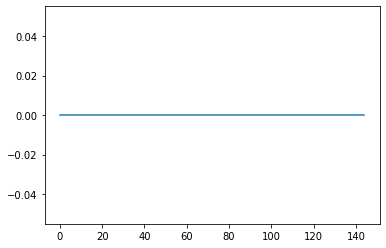

Net Div: 0.0
 To  solve  the  expression   1 4  +   5  *   3 4 ,  we  need  to  follow  the  order  of  operations ,  which  is  Par enth eses ,  Ex ponents ,  Mult ip lication  and  Division  ( from  left  to  right ),  Add ition  and  Sub tra ction  ( from  left  to  right ).  This  rule  is  often  abbre vi ated  as  P E MD AS . <0x0A> <0x0A> In  this  expression ,  there  are  no  parentheses  or  ex ponents ,  so  we  move  on  to  multiplication : <0x0A> <0x0A> 5  *   3 4  =   1 7 0 <0x0A> <0x0A> Now ,  we  perform  the  addition : <0x0A> <0x0A> 1 4  +   1 7 0  =   1 8 4 <0x0A> <0x0A> So ,   1 4  +   5  *   3 4  equals   1 8 4 .
159
146 32064
146 1


In [20]:

from matplotlib import pyplot as plt
import scatter_grid as sg

rev_vocab = {v:k for k,v in vocab.items()}
gen_logits = get_generated_logits(response)
print(len(gen_logits))
gen_scores = get_generated_scores(response)
print(gen_scores.shape)
logits = response.get("logits")
net_div = 0
divs = []
build_html_page(response, rev_vocab, SAMPLE)
for i in range(0,len(gen_logits)):
    gen_logit = gen_logits[i]
    gen_score = gen_scores[i]
    max = np.max(gen_score)
    logit_score = get_score_by_logit(gen_logit,gen_score)
    _txt = to_text([gen_logit], rev_vocab)
    # print(_txt, gen_logit)
    # print("Logit Score:",logit_score)
    # print("Max:",max)
    divs.append((max-logit_score)/max)
    net_div += max-logit_score

plt.plot(divs)
plt.show()
print("Net Div:",net_div)



print(to_text(get_generated_logits(response), rev_vocab))
print(len(logits[-1][0]))
resp_score = response.get("scores")
print(len(resp_score),len(resp_score[0][0]))
logit_scores = normalise_scores(resp_score)
print(len(logits), len(resp_score[0]))
txt_resp = response.get("response")[1].get("content")


In [21]:

# print(txt_resp)

# print(len(logits), len(logit_scores))

# LOGITS_LEN = len(logits)
# N = 10

# scoresN = []
# scoresFull = []
# std_metric = []
# mean_metric = []
# top2_metric = []    
# idx = list([i for i in range(0,len(resp_score[0]))])

# txt = ""


# for i in range(0,len(logits)):
#     scores = logit_scores[i]
#     #print(np.argmax(scores), np.max(scores), rev_vocab[np.argmax(scores)],rev_vocab[logits[i+1][0][-1]])
#     topN = get_scored_tokens(scores, rev_vocab, N)
#     print(f"Top N: {topN}")
#     scoreN = [i["s"] for i in topN]
#     metric_std, stdScoreN, stdScoreFull = eval_std_compare(scoreN, scores)
#     metric_top2 = eval_top_compare(scoreN[0],scoreN[1])
#     metric_m, mScoreN, mScoreFull = eval_mean_compare(scoreN, scores)

#     std_metric.append(metric_std)
#     mean_metric.append(metric_m)
#     top2_metric.append(metric_top2)
#     token=rev_vocab[np.argmax(logit_scores[i])].replace("▁"," ")
#     if token == "<0x0A>":
#         txt+=f"<br/><a data='{metric_top2}' class='{identify_css_class(metric_top2)}'>-</a>"
#     else:
#         txt += f"<a data='{metric_top2}' class='{identify_css_class(metric_top2)}'>{token}</a>"
#     # print(f"{i} {stdScoreFull, stdScoreN, mScoreFull, mScoreN, np.min(scores)}") 
#     print(topN)
#     print(f"Text: {topN[0]['v']}")
#     print(f"Text: {rev_vocab[np.argmax(logit_scores[i])]}")
#     print("\n")

# print(txt)

# write_html(txt)
# #plt.show()
# print(">>>", len(std_metric), len(top2_metric))
# len_metric = len(std_metric)
# plt.plot(mean_metric,'.')
# plt.hlines(1, 0, len_metric)

# plt.show()

# plt.plot(top2_metric,'.')
# plt.hlines(0, 0, len_metric)
# plt.hlines(50, 0, len_metric)
# for i  in range(LOGITS_LEN):
#     plt.annotate(rev_vocab[np.argmax(logit_scores[i])], (i, top2_metric[i]))
# plt.show()

# plt.plot(mean_metric,std_metric,'.')